# CMP STEP 8: Validating Clusters

In [ ]:
NOT_LINUX = False  # set to True, if you have trouble replicating results with your operating system

In [1]:
### FINAL UMAP PARAMETERS ###

N_NEIGHBORS = 30
MIN_DIST = 0.01
N_COMPONENTS = 30
METRIC_UMAP = 'cosine'
RANDOM_STATE = 86531  # masked

### FINAL HDBSCAN PARAMETERS ###

MIN_CLUSTER_SIZE = 10
MIN_SAMPLES = 30
METRIC_HDBSCAN = 'euclidean'

EMBEDDINGS = 'data/'

In [2]:
import numpy as np
import pandas as pd

import umap
import hdbscan

import os
import random

import matplotlib.pyplot as plt

/home/alina/anaconda3/envs/umap_hdbscan/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load strategy texts & embeddings

In [3]:
# load raw strategy sentences
data = pd.read_csv(EMBEDDINGS + 'strategies_raw.csv', sep=';')
strategies = data['strategy text'].tolist()

In [4]:
# load strategy embeddings and convert to numpy array
strategy_embeddings = np.load(EMBEDDINGS + 'strategy_embeddings_masked.npy')

### Define helper functions

In [5]:
def umap_hdbscan(embeds=strategy_embeddings,
                 n_neighbors=N_NEIGHBORS,
                 min_dist=MIN_DIST,
                 n_components=N_COMPONENTS,
                 random_state=RANDOM_STATE,
                 min_cluster_size=MIN_CLUSTER_SIZE,
                 min_samples=MIN_SAMPLES):
    if NOT_LINUX == True:
        umap_embed_fin = np.load(EMBEDDINGS + f'not_linux/umap_embeddings_seed-{RANDOM_STATE}-(final).npy')
    else:
        umap_fin = umap.UMAP(n_neighbors=n_neighbors,
                             min_dist=min_dist,
                             n_components=n_components,
                             metric='cosine',
                             random_state=random_state).fit(embeds)
                             # gives majority of cluster solutions of 1.000 different UMAP seeds

        umap_embed_fin = umap_fin.transform(embeds)

    hdbscan_fin = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                  min_samples=min_samples,
                                  metric='euclidean')

    hdbscan_fin.fit(umap_embed_fin)
    
    return hdbscan_fin


# produce intrusion task survey
def sentence_intrusion_survey(hdbscan, k=4, items=[], random_state=15):
    """ draws pre-calculated number of intrusion items
        3 sentences of each item belong to the same cluster and 1 (the intruder) belongs to a different cluster
        intrusion task items and answers are shuffled and stored in a txt file"""

    if os.path.exists('intrusion/survey/survey.txt'):
        os.remove('intrusion/survey/survey.txt')

    if os.path.exists('intrusion/survey_solution.txt'):
        os.remove('intrusion/survey_solution.txt')
    
    solutions = []
    tasks = []
    random.seed(random_state)
    
    for cluster in range(max(hdbscan.labels_) + 1):
            
        cluster_sentences = [i for i in np.delete(strategies, np.where(
                              hdbscan.labels_ != cluster), axis=0)]
        sentences = random.sample(cluster_sentences, k=(k-1)*items[cluster])
        
        intruder_sentences = [i for i in np.delete(strategies,
                                            list(np.where(hdbscan.labels_ == cluster)[0]) + list(np.where(hdbscan.labels_ == -1)[0]),
                                            axis=0)]
        intruders = random.sample(intruder_sentences, k=items[cluster])
        
        for x, y in enumerate(np.arange(k-2, len(sentences), k-1)):
            task = sentences[y-(k-2):y+1]
            task.append(intruders[x])
            random.shuffle(task)
            solutions.append((cluster, task.index(intruders[x])))
            tasks.append(task)
    
    shuffle_temp = list(zip(tasks, solutions))
    random.shuffle(shuffle_temp)
    tasks, solutions = zip(*shuffle_temp)
    
    with open('intrusion/survey/survey.txt', 'a') as f:
        for i in range(len(tasks)):
            f.write('\n')
            f.write(f'ITEM {i+1}')
            for j in range(k):
                f.write('\n')
                f.write(tasks[i][j])
            f.write('\n')
        
    with open('intrusion/survey_solution.txt', 'a') as f:
        f.write('Item, Cluster, Solution')
        f.write('\n')
        for z in range(len(solutions)):
            f.write(f'{z+1}, {solutions[z][0]}, {solutions[z][1]}')
            f.write('\n')

### Recreate final solution

In [6]:
hdbscan_fin = umap_hdbscan(embeds=strategy_embeddings)
# cross-check number of clusters (37) & unclustered points (3067)
print(f'Number of clusters: {max(hdbscan_fin.labels_ + 1)}')
print(f'Number of unclustered points: {list(hdbscan_fin.labels_).count(-1)}')

Number of clusters: 37
Number of unclustered points: 3067


### Draw intrusion survey items

In [7]:
# evaluate aproxx./at least 30% of sentences per cluster
items_per_cluster = [int(3 * np.ceil(list(hdbscan_fin.labels_).count(x) * 0.3 / 3) / 3
                        ) for x in range(max(hdbscan_fin.labels_) + 1)]
# items_per_cluster = [16, 7, 7, 12, 18, 10, 8, 12, 5, 9, 11, 5, 4, 7, 10, 4, 8, 19, 5, 14,
#                      4, 12, 4, 20, 12, 8, 3, 5, 6, 6, 4, 4, 5, 20, 5, 5, 2]
sentence_intrusion_survey(hdbscan_fin, items=items_per_cluster)

### Analyze intrusion results

In [8]:
def read_survey(group=1):
    """ function for reading survey data from LimeSurvey's exported csv files """
    g = pd.read_csv(f'intrusion/results/results_group_{group}.csv')
    g = g.drop(columns=['id', 'submitdate', 'lastpage', 'startlanguage', 'seed', 'langcontrol'])
    g = g.replace({'A1': 0, 'A2': 1, 'A3': 2, 'A4': 3})
    if group == 1:
        g.columns = [f'Q{i+1}' for i in range(g.shape[1])]
    
    return g

In [9]:
# read separate data files
group_1 = read_survey()
group_2 = read_survey(group=2)
group_3 = read_survey(group=3)
group_4 = read_survey(group=4)
group_5 = read_survey(group=5)
group_6 = read_survey(group=6)

# concat separate survey groups into one dataframe
survey = pd.concat([group_1, group_2, group_3, group_4, group_5, group_6], axis=1)
survey.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q307,Q308,Q309,Q310,Q311,Q312,Q313,Q314,Q315,Q316
0,2,2,2,3,2,0,0,3,3,2,...,0,0,2,2,3,2,0,3,1,1
1,2,2,2,3,2,0,0,0,3,2,...,0,0,2,2,3,2,0,3,3,0
2,2,2,2,3,2,3,0,0,3,2,...,0,0,2,2,3,2,0,3,1,1
3,2,2,2,3,2,0,0,2,3,2,...,0,0,2,2,3,2,0,3,1,0


In [10]:
# read 'right' answers to survey questions
solution = pd.read_csv('intrusion/survey_solution.txt')
solution.columns = ['Item', 'Cluster', 'Solution']
solution.head()

,Item,Cluster,Solution
0,1,7,2
1,2,11,2
2,3,16,2
3,4,34,3
4,5,24,2


In [11]:
# construct dataframe with 0 for false and 1 for right answers
array = np.zeros(survey.shape)

for i in range(survey.shape[1]):
    d = {0: 0, 1: 0, 2: 0, 3: 0}
    d[solution.Solution.iloc[i]] = 1
    array[:, i] = [d[x] for x in list(survey[f'Q{i+1}'])]

survey_yn = pd.DataFrame(array.astype(int))
survey_yn.columns = list(range(1, 317))
survey_yn.head()

,1,2,3,4,5,6,7,8,9,10,...,307,308,309,310,311,312,313,314,315,316
0,1,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
1,1,1,1,1,1,0,1,0,1,1,...,1,1,1,1,1,1,1,1,0,1
2,1,1,1,1,1,0,1,0,1,1,...,1,1,1,1,1,1,1,1,1,0
3,1,1,1,1,1,0,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1


In [12]:
# calculate fraction of found intruders per item
frac = [(sum(list(survey_yn[x])) / 4) for x in range(1, 317)]

# sum up fractions per cluster and store in cluster dict along with items per cluster
raw_tuples = [(x, [0, 0]) for x in range(max(solution.Cluster)+1)]
sum_dict = dict((x, y) for x, y in raw_tuples)

for i in range(len(solution)):
    sum_dict[solution.loc[i].Cluster][0] = sum_dict[solution.loc[i].Cluster][0] + frac[i]
    sum_dict[solution.loc[i].Cluster][1] = sum_dict[solution.loc[i].Cluster][1] + 1

In [13]:
# calculate final results: average fraction of found intruders per cluster
print('INTRUSION SURVEY RESULTS')
print('Cluster, Fraction')
for i in sum_dict:
    print(f'{i}, {(sum_dict[i][0] / sum_dict[i][1]):.2f}')

# store results in file
with open('intrusion/intrusion_survey_results.txt', 'w') as file:
    file.write('Cluster, Fraction\n')
    for i in sum_dict:
        file.write(f'{i}, {(sum_dict[i][0] / sum_dict[i][1]):.2f}')
        file.write('\n')

INTRUSION SURVEY RESULTS
Cluster, Fraction
0, 0.34
1, 0.96
2, 0.96
3, 0.94
4, 0.79
5, 0.97
6, 0.91
7, 0.88
8, 0.65
9, 0.86
10, 0.75
11, 1.00
12, 0.94
13, 0.96
14, 0.95
15, 0.75
16, 0.91
17, 0.88
18, 0.85
19, 0.89
20, 1.00
21, 0.85
22, 0.44
23, 0.76
24, 0.83
25, 0.88
26, 1.00
27, 0.85
28, 1.00
29, 0.96
30, 0.81
31, 0.94
32, 1.00
33, 0.79
34, 0.80
35, 0.90
36, 1.00


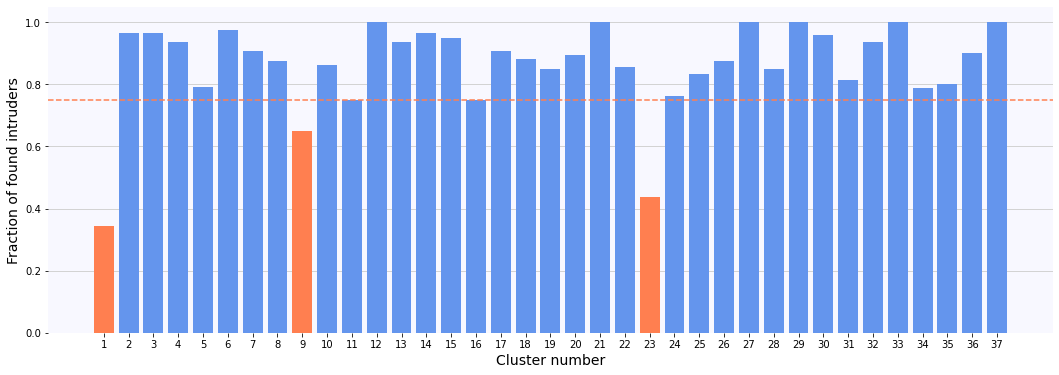

In [14]:
# plot fraction of found intruders per cluster (bar plot)
frac_overall = [(sum_dict[x][0] / sum_dict[x][1]) for x in sum_dict]

fig, ax = plt.subplots(figsize=(18, 6))

for pos in ('top', 'right', 'bottom', 'left'):
    ax.spines[pos].set_visible(False)

c = ['cornflowerblue'] * len(frac_overall)
for i in (0, 8, 22):
    c[i] = 'coral'
y_pos = np.arange(len(frac_overall))

ax.set_facecolor('ghostwhite')
ax.bar(y_pos, frac_overall, align='center', color=c)
ax.axhline(y=0.75, color='coral', linestyle='--')
ax.grid(axis='y', color='lightgrey', linewidth=1)
ax.set_axisbelow(True)
ax.set_xticks(y_pos, labels=np.arange(1, len(frac_overall)+1))
ax.set_ylabel('Fraction of found intruders', fontsize=14)
ax.set_xlabel('Cluster number', fontsize=14)

plt.savefig('intrusion/fraction_intruders_per_cluster.svg')

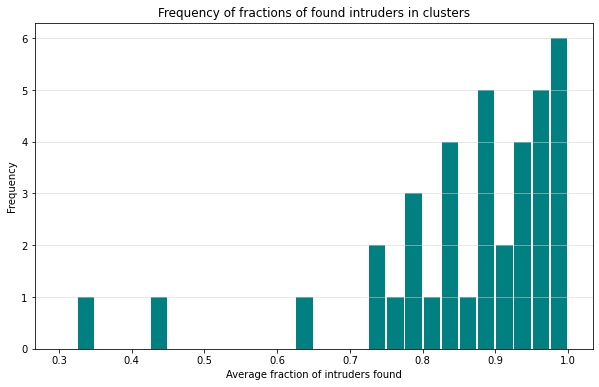

In [15]:
# visualize distribution of fraction of found intruders in clusters
survey_analysis = pd.read_csv('intrusion/intrusion_survey_results.txt')
survey_analysis.columns = ['Cluster', 'Fraction']

plt.figure(figsize=(10,6))
plt.hist(survey_analysis.Fraction, bins=np.arange(0.3, 1.01, 0.025), rwidth=0.9, color='teal')
plt.grid(axis='y', color='lightgrey', linewidth=0.5)
plt.xlabel('Average fraction of intruders found')
plt.ylabel('Frequency')
plt.title('Frequency of fractions of found intruders in clusters')

plt.savefig('intrusion/fraction_found_intruders_hist.svg')